In [1181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import chart_studio.plotly as py
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error

In [1182]:
#Loading datasets
cuisine = pd.read_csv('chefmozcuisine.csv')
user_cuisine = pd.read_csv('usercuisine.csv')
user_profile = pd.read_csv('userprofile.csv')
ratings = pd.read_csv('rating_final.csv')
accepts = pd.read_csv('chefmozaccepts.csv')
hours = pd.read_csv('chefmozhours4.csv')
cuisine[['placeID', 'Rcuisine']][270:310]

,placeID,Rcuisine
270,132856,Italian
271,132855,Mexican
272,132854,International
273,132853,Fast_Food
274,132852,Latin_American
275,132852,Mexican
276,132851,American
277,132851,Game
278,132846,International
279,132845,Mexican


In [1183]:
user_prof_ratings = pd.merge(user_profile, ratings, on='userID')
df = pd.merge(user_prof_ratings, cuisine, on='placeID', how='left')
#df = user_prof_rate_cuisine
df[df.Rcuisine.isna()]

,userID,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,...,activity,color,weight,budget,height,placeID,rating,food_rating,service_rating,Rcuisine
0,U1001,22.139997,-100.978803,false,abstemious,informal,family,on foot,single,independent,...,student,black,69,medium,1.77,132830,1,1,1,NaN
3,U1001,22.139997,-100.978803,false,abstemious,informal,family,on foot,single,independent,...,student,black,69,medium,1.77,135040,1,1,1,NaN
5,U1001,22.139997,-100.978803,false,abstemious,informal,family,on foot,single,independent,...,student,black,69,medium,1.77,135045,1,1,1,NaN
6,U1001,22.139997,-100.978803,false,abstemious,informal,family,on foot,single,independent,...,student,black,69,medium,1.77,135033,1,1,1,NaN
8,U1001,22.139997,-100.978803,false,abstemious,informal,family,on foot,single,independent,...,student,black,69,medium,1.77,135051,1,1,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296,U1135,22.170396,-100.949936,false,casual drinker,informal,family,on foot,single,kids,...,student,purple,66,low,1.54,135063,0,0,0,NaN
1298,U1135,22.170396,-100.949936,false,casual drinker,informal,family,on foot,single,kids,...,student,purple,66,low,1.54,135045,0,0,0,NaN
1309,U1136,22.149607,-100.997235,true,social drinker,no preference,friends,car owner,single,independent,...,student,black,50,low,1.60,135064,1,1,1,NaN
1320,U1137,22.144803,-100.944623,false,social drinker,formal,family,public,single,independent,...,student,blue,72,low,1.78,135062,2,2,2,NaN


In [1184]:
df.columns

Index(['userID', 'latitude', 'longitude', 'smoker', 'drink_level',
       'dress_preference', 'ambience', 'transport', 'marital_status', 'hijos',
       'birth_year', 'interest', 'personality', 'religion', 'activity',
       'color', 'weight', 'budget', 'height', 'placeID', 'rating',
       'food_rating', 'service_rating', 'Rcuisine'],
      dtype='object')

In [1185]:
#Assign random value to ? based on proportion
false_prob = len(df[df.smoker == 'false']) / len(df[df.smoker != '?'])
true_prob = len(df[df.smoker == 'true']) / len(df[df.smoker != '?'])
smoker_nan = list(df[df.smoker == '?'].index)
for i in smoker_nan:
    df['smoker'][i] = df['smoker'][i].replace('?', np.random.choice(['false','true'], p=[false_prob, true_prob]))

df['dress_preference'].value_counts(normalize=True)
dress_preference_nan = list(df[df.dress_preference == '?'].index)
for i in dress_preference_nan:
    df['dress_preference'][i] = df['dress_preference'][i].replace('?', 
    np.random.choice(['no preference','formal', 'informal', 'elegant'], 
    p=[0.336529/ 0.958773, 0.318313/0.958773, 0.279962/0.958773, 0.023969/0.958773]))

fam_prob = len(df[df.ambience == 'family']) / len(df[df.ambience != '?'])
friends_prob = len(df[df.ambience == 'friends']) / len(df[df.ambience != '?'])
sol_prob = len(df[df.ambience == 'solitary']) / len(df[df.ambience != '?'])
amb_nan = list(df[df.ambience == '?'].index)
for i in amb_nan:
     df['ambience'][i] = df['ambience'][i].replace('?', 
    np.random.choice(['family','friends', 'solitary'], 
    p=[fam_prob , friends_prob, sol_prob]))

pub_prob = len(df[df.transport == 'public']) / len(df[df.transport != '?'])
car_prob = len(df[df.transport == 'car owner']) / len(df[df.transport != '?'])
foot_prob = len(df[df.transport == 'on foot']) / len(df[df.transport != '?'])
trans_nan = list(df[df.transport == '?'].index)
for i in trans_nan:
     df['transport'][i] = df['transport'][i].replace('?', 
    np.random.choice(['public','car owner', 'on foot'], 
    p= [pub_prob , car_prob, foot_prob]))

single_prob = len(df[df.marital_status == 'single']) / len(df[df.marital_status != '?'])
married_prob = len(df[df.marital_status == 'married']) / len(df[df.marital_status != '?'])
widow_prob = len(df[df.marital_status == 'widow']) / len(df[df.marital_status != '?'])
mar_nan = list(df[df.marital_status == '?'].index)
for i in mar_nan:
     df['marital_status'][i] = df['marital_status'][i].replace('?', 
    np.random.choice(['single','married', 'widow'], 
    p= [single_prob , married_prob, widow_prob]))


In [1213]:
ind_prob = len(df[df.hijos == 'independent']) / len(df[df.hijos != '?'])
kids_prob = len(df[df.hijos == 'kids']) / len(df[df.hijos != '?'])
dep_prob = len(df[df.hijos == 'dependent']) / len(df[df.hijos != '?'])
hijos_nan = list(df[df.hijos == '?'].index)
for i in hijos_nan:
     df['hijos'][i] = df['hijos'][i].replace('?', 
    np.random.choice(['independent','kids', 'dependent'], 
    p= [ind_prob , kids_prob, dep_prob]))
        
stu_prob = len(df[df.activity == 'student']) / len(df[df.activity != '?'])
prof_prob = len(df[df.activity == 'professional']) / len(df[df.activity != '?'])
unemp_prob = len(df[df.activity == 'unemployed']) / len(df[df.activity != '?'])
work_prob = len(df[df.activity == 'working-class']) / len(df[df.activity != '?'])
act_nan = list(df[df.activity == '?'].index)
for i in act_nan:
     df['activity'][i] = df['activity'][i].replace('?', 
    np.random.choice(['student','professional', 'unemployed', 'working-class'], 
    p= [stu_prob , prof_prob, unemp_prob, work_prob]))
        
low_prob = len(df[df.budget == 'low']) / len(df[df.budget != '?'])
med_prob = len(df[df.budget == 'medium']) / len(df[df.budget != '?'])
high_prob = len(df[df.budget == 'high']) / len(df[df.budget != '?'])
budg_nan = list(df[df.budget == '?'].index)
for i in budg_nan:
     df['budget'][i] = df['budget'][i].replace('?', 
    np.random.choice(['low','medium', 'high'], 
    p= [low_prob , med_prob, high_prob]))

cuisine_nan = list(df[df.Rcuisine.isna() == True].index)
cuisine_names = list(df['Rcuisine'].value_counts(normalize=True).index)
for i in cuisine_nan:
    df['Rcuisine'][i] = np.random.choice(cuisine_names, p=cuisine_prob)

In [1214]:
warnings.filterwarnings('ignore')
df['userID'] = df['userID'].str.slice(2)

df['smoker_cat'] = df['smoker'].astype('category')
df['smoker_cat'] = df['smoker_cat'].cat.codes

df['drink_level_cat'] = df['drink_level'].astype('category')
df['drink_level_cat'] = df['drink_level_cat'].cat.codes

df['dress_preference_cat'] = df['dress_preference'].astype('category')
df['dress_preference_cat'] = df['dress_preference_cat'].cat.codes
df['ambience_cat'] = df['ambience'].astype('category')
df['ambience_cat'] = df['ambience_cat'].cat.codes
df['transport_cat'] = df['transport'].astype('category')
df['transport_cat'] = df['transport_cat'].cat.codes
df['marital_status_cat'] = df['marital_status'].astype('category')
df['marital_status_cat'] = df['marital_status_cat'].cat.codes
df['hijos_cat'] = df['hijos'].astype('category')
df['hijos_cat'] = df['hijos_cat'].cat.codes
df['interest_cat'] = df['interest'].astype('category')
df['interest_cat'] = df['interest_cat'].cat.codes
df['personality_cat'] = df['personality'].astype('category')
df['personality_cat'] = df['personality_cat'].cat.codes
df['religion_cat'] = df['religion'].astype('category')
df['religion_cat'] = df['religion_cat'].cat.codes
df['activity_cat'] = df['activity'].astype('category')
df['activity_cat'] = df['activity_cat'].cat.codes
df['color_cat'] = df['color'].astype('category')
df['color_cat'] = df['color_cat'].cat.codes
df['budget_cat'] = df['budget'].astype('category')
df['budget_cat'] = df['budget_cat'].cat.codes
df['Rcuisine_cat'] = df['Rcuisine'].astype('category')
df['Rcuisine_cat'] = df['Rcuisine_cat'].cat.codes

In [1216]:
df['Rcuisine'].nunique()

23

In [1217]:
df.columns

Index(['userID', 'latitude', 'longitude', 'smoker', 'drink_level',
       'dress_preference', 'ambience', 'transport', 'marital_status', 'hijos',
       'birth_year', 'interest', 'personality', 'religion', 'activity',
       'color', 'weight', 'budget', 'height', 'placeID', 'rating',
       'food_rating', 'service_rating', 'Rcuisine', 'smoker_cat',
       'drink_level_cat', 'dress_preference_cat', 'ambience_cat',
       'transport_cat', 'marital_status_cat', 'hijos_cat', 'interest_cat',
       'personality_cat', 'religion_cat', 'activity_cat', 'color_cat',
       'budget_cat', 'Rcuisine_cat'],
      dtype='object')

In [1218]:
df_cat = df[['userID', 'latitude', 'longitude','weight', 'height', 'placeID', 'rating',
       'food_rating', 'service_rating', 'smoker_cat',
       'interest_cat', 'Rcuisine_cat', 'marital_status_cat', 'budget_cat',
       'personality_cat', 'drink_level_cat', 'dress_preference_cat',
       'ambience_cat', 'transport_cat', 'hijos_cat', 'religion_cat',
       'activity_cat', 'color_cat']]

df_cat

,userID,latitude,longitude,weight,height,placeID,rating,food_rating,service_rating,smoker_cat,...,budget_cat,personality_cat,drink_level_cat,dress_preference_cat,ambience_cat,transport_cat,hijos_cat,religion_cat,activity_cat,color_cat
0,1,22.139997,-100.978803,69,1.77,132830,1,1,1,0,...,2,3,0,2,0,1,1,4,1,0
1,1,22.139997,-100.978803,69,1.77,132825,2,2,1,0,...,2,3,0,2,0,1,1,4,1,0
2,1,22.139997,-100.978803,69,1.77,135085,0,1,1,0,...,2,3,0,2,0,1,1,4,1,0
3,1,22.139997,-100.978803,69,1.77,135040,1,1,1,0,...,2,3,0,2,0,1,1,4,1,0
4,1,22.139997,-100.978803,69,1.77,135039,1,1,1,0,...,2,3,0,2,0,1,1,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,7,22.144803,-100.944623,72,1.78,135049,2,2,2,0,...,1,1,2,1,0,2,1,0,1,1
1327,7,22.144803,-100.944623,72,1.78,135075,2,2,2,0,...,1,1,2,1,0,2,1,0,1,1
1328,8,22.152884,-100.939663,54,1.55,132921,2,2,1,0,...,2,3,2,1,1,2,1,4,1,1
1329,8,22.152884,-100.939663,54,1.55,132922,2,2,2,0,...,2,3,2,1,1,2,1,4,1,1


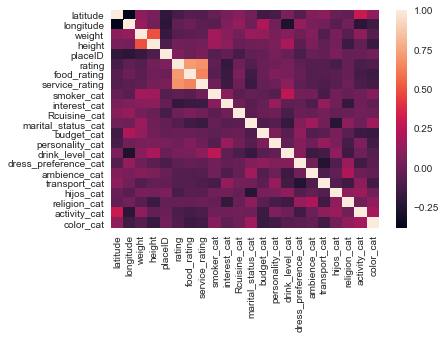

In [1219]:
#Checking correlations of all the variables. No one variable is very good at predicting rating.
corr = df_cat.corr()
_ = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

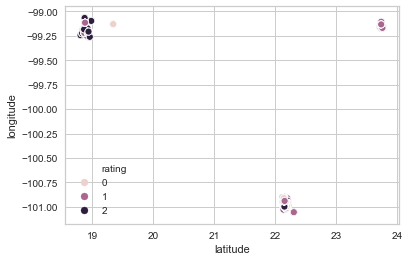

In [1227]:
#Many of the higher rated restaurants cluster around the same area. 
sns.scatterplot(df.latitude, df.longitude, hue=df.rating)

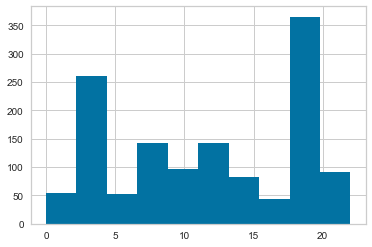

In [1226]:
df['Rcuisine_cat'].hist()

In [1244]:
#Checking for normal distribution...
#Null hypothesis: The data is normally distributed
#Alternate hypothesis: The data is not normally distributed
chi_weight, p_weight = stats.chisquare(df.weight)
chi_height, p_height = stats.chisquare(df.height)
chi_cuisine, p_cuisine = stats.chisquare(df.Rcuisine_cat)

def check_distribution(p):
    if p < 0.05:
        print('The p-value of the chi-square test of the series is {}, therefore we reject the null hypothesis.'
              .format(p))
        print('The series is not normally distributed.')
    else:
        print('The p-value of the chi-square test of the series is {}, therefore we fail to reject the null hypothesis.'
              .format(p))
        print('The series is normally distributed.')

check_distribution(p_weight)
check_distribution(p_height)
check_distribution(p_cuisine)


The p-value of the chi-square test of the series is 0.0, therefore we reject the null hypothesis.
The series is not normally distributed.
The p-value of the chi-square test of the series is 1.0, therefore we fail to reject the null hypothesis.
The series is normally distributed.
The p-value of the chi-square test of the series is 0.0, therefore we reject the null hypothesis.
The series is not normally distributed.


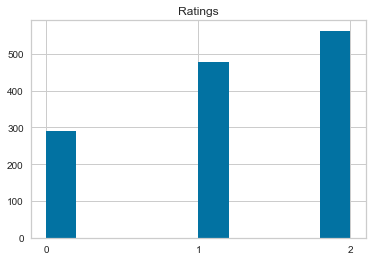

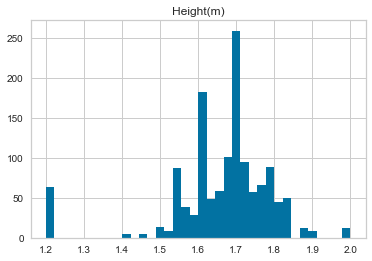

Text(0.5, 1.0, 'Weight(kg)')

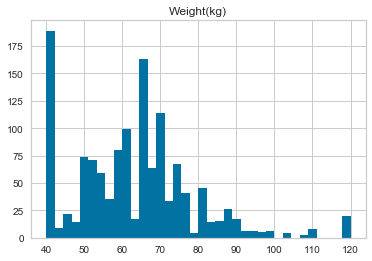

In [1225]:
df['rating'].hist()
plt.xticks(np.arange(0, 3, step=1))
plt.title('Ratings')
plt.show()

df['height'].hist(bins=int(np.sqrt(len(df['height']))))
plt.title('Height(m)')
plt.show()

df.weight.hist(bins=int(np.sqrt(len(df['weight']))))
plt.title('Weight(kg)')

In [1206]:
food_rating_ols = ols('Q("rating") ~ Q("food_rating")', df).fit()
food_rating_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Q("rating")   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     1405.
Date:                Thu, 16 Jul 2020   Prob (F-statistic):          2.03e-210
Time:                        22:54:30   Log-Likelihood:                -1068.4
No. Observations:                1331   AIC:                             2141.
Df Residuals:                    1329   BIC:                             2151.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3611      0.027     13.404      0.000       0.308       0.414
Q("food_rating")     0.7006      0.019     37.484      0.000       0.664       0.737
==============================================================================
Omnibus:                       30.966   Durbin-Watson:                   1.465
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.396
Skew:                          -0.173   Prob(JB):                     2.54e-12
Kurtosis:                       3.918   Cond. No.                         3.61
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1246]:
serv_rating_ols = ols('Q("rating") ~ Q("service_rating")', df).fit()
serv_rating_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Q("rating")   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     1211.
Date:                Fri, 17 Jul 2020   Prob (F-statistic):          3.86e-189
Time:                        17:57:49   Log-Likelihood:                -1117.5
No. Observations:                1331   AIC:                             2239.
Df Residuals:                    1329   BIC:                             2249.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.4666      0.026     17.820      0.000       0.415       0.518
Q("service_rating")     0.6767      0.019     34.798      0.000       0.639       0.715
==============================================================================
Omnibus:                       28.314   Durbin-Watson:                   1.401
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.862
Skew:                           0.254   Prob(JB):                     9.90e-09
Kurtosis:                       3.638   Cond. No.                         3.25
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1207]:
X = df_cat.drop(['rating', 'food_rating', 'service_rating'], axis=1)
y = df_cat['rating']
#result = list()
#for i in range(1000):
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)
y_pred = rf_reg.predict(X_test)
    #result.append(mean_absolute_error(y_test, y_pred))
print(rf_reg.score(X_test, y_test))
#print('Mean Absolute Error: {}'.format(np.mean(result)))

0.2608606557377048


In [1208]:
parameters = {'max_depth': list(range(1,10)),
              'n_estimators': list(range(1,20)),
              'max_features': list(range(1,10))
                            
}

rf_reg_cv = GridSearchCV(rf_reg, parameters, cv=3)
rf_reg_cv.fit(X_train, y_train)
print('Tuned Random Forest Regressor Parameters: {}'.format(rf_reg_cv.best_params_))
print('Best score is {}'.format(rf_reg_cv.best_score_))

Tuned Random Forest Regressor Parameters: {'max_depth': 9, 'max_features': 7, 'n_estimators': 19}
Best score is 0.29068491642877003


In [1209]:
print('R^2: {}'.format(rf_reg_cv.score(X_test, y_test)))
y_pred_cv = rf_reg_cv.predict(X_test)
mae= mean_absolute_error(y_test, y_pred_cv)
print('Mean Absolute Error: {}'.format(mae))

R^2: 0.35427462596334525
Mean Absolute Error: 0.5050640628646137


In [1210]:
X = df_cat.drop(['rating', 'food_rating', 'service_rating'], axis=1)
y = df_cat['rating']
#result = list()
#for i in range(1000):
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
sel = SelectFromModel(RandomForestClassifier(n_estimators=100))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,
                                                 random_state=None, verbose=0,
  

In [1211]:
sel.get_support()
selected_feat = X_train.columns[(sel.get_support())]
print(selected_feat)

Index(['userID', 'latitude', 'longitude', 'height', 'placeID', 'Rcuisine_cat'], dtype='object')


In [1231]:
X_2 = df_cat[['userID', 'latitude', 'longitude', 'weight', 'height', 'placeID','Rcuisine_cat']]
y_2 = df_cat['rating']
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.3, random_state=42)
model = RandomForestRegressor()
model.fit(X_2_train, y_2_train)
y_pred = rf_reg.predict(X_2_test)
print(rf_reg.score(X_2_test, y_2_test))

ValueError: Number of features of the model must match the input. Model n_features is 20 and input n_features is 7 

In [ ]:
parameters = {'max_depth': list(range(1,20)),
              'n_estimators': list(range(1,10)),
              'max_features': list(range(1,7))
                            
}

model_cv = GridSearchCV(model, parameters, cv=3)
model_cv.fit(X_train, y_train)
print('Tuned Random Forest Regressor Parameters: {}'.format(model_cv.best_params_))
print('Best score is {}'.format(model_cv.best_score_))

In [ ]:
print('R^2: {}'.format(model_cv.score(X_test, y_test)))

In [ ]:
user_info = df_cat.set_index('userID')
user_info

In [ ]:
def compute_rmse(y_pred, y_true):
    """ Compute Root Mean Squared Error. """
    
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))

def evaluate(estimate_f): 
    ids_to_estimate = zip(df_cat.userID, df_cat.placeID)
    estimated = np.array([estimate_f(u,i) for (u,i) in ids_to_estimate])
    real = df_cat.rating.values
    return compute_rmse(estimated, real)
def my_estimate_function(userID, placeID):
    return 3
print('RMSE for my estimate function: %s' % evaluate(my_estimate_function))

In [ ]:
ratings_mtx_df = df_cat.pivot_table(values='rating',
                                             index='userID',
                                             columns='placeID')
ratings_mtx_df

In [1235]:
def pearson(s1, s2):
    s1_c = s1 - s1.mean()
    s2_c = s2 - s2.mean()
    return np.sum(s1_c * s2_c) / np.sqrt(np.sum(s1_c ** 2) * np.sum(s2_c ** 2))
class CollabPearsonReco:
    def learn(self):
        self.all_user_profiles = df_cat.pivot_table('rating', index='placeID', columns='userID')
    def estimate(self, userID, placeID):
        user_condition = df_cat.userID != userID
        place_condition = df_cat.placeID == placeID
        ratings_by_others = df_cat.loc[user_condition & place_condition]
        if ratings_by_others.empty: 
            return 3.0
        
        ratings_by_others.set_index('userID', inplace=True)
        their_ids = ratings_by_others.index
        their_ratings = ratings_by_others.rating
        their_profiles = self.all_user_profiles[their_ids]
        user_profile = self.all_user_profiles[userID]
        sims = their_profiles.apply(lambda profile: pearson(profile, user_profile), axis=0)
        ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
        ratings_sims = ratings_sims[ratings_sims.sim > 0]
        if ratings_sims.empty:
            return their_ratings.mean()
        else:
            return np.average(ratings_sims.rating, weights=ratings_sims.sim)
        
reco = CollabPearsonReco()
reco.learn()
print('RMSE for CollabPearsonReco: %s' % evaluate(reco.estimate))

RMSE for CollabPearsonReco: 0.8209088466878963
